In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from tqdm.notebook import tqdm
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)

%matplotlib inline

In [2]:
# load residual abundance catalog
with fits.open('2process_residual_abund_catalog_final.fits') as hdul:
    twoprocess_data = hdul[1].data

In the below function, we match entries by `APOGEE_ID` and `LOCATION_ID` to ensure we are matching unique entries; this may result in multiple entries with the same `APOGEE_ID`. You can remove duplicates from the residual abundance catalog by selecting only entries with `DFLAG=0`. Alternatively, if you want to select all stars with the same `APOGEE_ID` irrespective of observing field, the function can be modified to match on only `APOGEE_ID`.

In [3]:
def cross_match_catalogs(catalog_1, catalog_2):
    """
    Function to cross-match catalogs of different sizes by APOGEE_ID and LOCATION_ID.
    Input
    -----
    larger_cat : recarray
                 Catalog with more rows, formatted as a numpy record array.
                 Must contain 'APOGEE_ID' and 'LOCATION_ID' columns.
    smaller_cat : recarray
                  Catalog with fewer rows, formatted as a numpy record array.
                  Must contain 'APOGEE_ID' and 'LOCATION_ID' columns.
    Output
    ------
    larger_cat_matched : recarray
                         Data from larger_cat for matched entries in smaller_cat.
                         Columns from larger_cat are preserved.
    smaller_cat_matched : recarray
                          Data from smaller_cat for matched entries in larger_cat.
                          Columns from smaller_cat are preserved.
    """
    # determine which catalog is larger and rename them
    if len(catalog_1)>=len(catalog_2):
        larger_cat = catalog_1
        smaller_cat = catalog_2
    elif len(catalog_1)<len(catalog_2):
        smaller_cat = catalog_1
        larger_cat = catalog_2
    
    # free up memory since we've renamed the catalogs
    del catalog_1, catalog_2
    
    # make an array that, for each entry in the smaller catalog, saves the index of the larger catalog match
    large_cat_inds = np.empty(len(smaller_cat['APOGEE_ID']))
    for i, ap_id in enumerate(tqdm(smaller_cat['APOGEE_ID'])):
        match_inds = np.where((larger_cat['APOGEE_ID']==ap_id) & (larger_cat['LOCATION_ID']==smaller_cat['LOCATION_ID'][i]))[0]
        if len(match_inds)==0: # no match
            large_cat_inds[i] = np.nan
        elif len(match_inds)==1:
            large_cat_inds[i] = match_inds[0]
        else:
            for match_ind in match_inds:
                if large_cat_inds[i-1]!=match_ind:
                    large_cat_inds[i] = match_ind
                    break                
            
    # if an entry in large_cat_inds is nan, that entry in the smaller array doesn't have a match
    small_with_large_data_bool = ~np.isnan(large_cat_inds)
    large_cat_inds = large_cat_inds[small_with_large_data_bool].astype(int)

    # filter input arrays - the order will follow that of the smaller catalog (with non-matching entries removed)
    smaller_cat_matched = smaller_cat[small_with_large_data_bool]
    larger_cat_matched = larger_cat[large_cat_inds]
    
    return larger_cat_matched, smaller_cat_matched

Note that in certain applications, it may be faster to read your input FITS files as `pandas` dataframes and use `pandas.merge()` with `on=['APOGEE_ID', 'LOCATION_ID']`. However, there may be issues if there are duplicate `APOGEE_ID`-`LOCATION_ID` pairs in either catalog; this slower implementation should keep all duplicate pairs at unique indices and preserve their order.

### Cross-match with AstroNN, then plot $A_{\rm Ia}$ and $A_{\rm cc}$ as a function of Galactic position
The DR17 AstroNN catalog (Leung & Bovy 2019a,b, Mackereth et al. 2019) can be accessed at: https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=the-astronn-catalog-of-abundances,-distances,-and-ages-for-apogee-dr17-stars

In [4]:
# load AstroNN catalog - adjust file path as necessary
with fits.open('apogee_astroNN-DR17.fits') as hdul:
    astronn_data = hdul[1].data

In [5]:
# cross-match the catalogs:
astronn_matched, twoprocess_matched = cross_match_catalogs(astronn_data, twoprocess_data)

  0%|          | 0/310427 [00:00<?, ?it/s]

Note that the above cell may take a long time to run; if you intend on working with similarly large catalogs it is recommended to cross-match once, then save the smaller cross-matched catalog to a separate FITS file to load for future use. For multiple large catalogs, you can save the cross-matched versions as separate extensions in one FITS file, which will preserve all original catalog columns. For example:

In [11]:
towrite_astronn = fits.BinTableHDU(data=astronn_matched)
towrite_twoproc = fits.BinTableHDU(data=twoprocess_matched)
towrite_primaryhdu = fits.PrimaryHDU()
towrite = fits.HDUList([towrite_primaryhdu, towrite_astronn, towrite_twoproc])
towrite.writeto('astroNN_2proc_crossmatch.fits')

Then, you can just skip the code cells after the import statements and run the following:

In [4]:
# load the cross-matched astroNN and residual abundance data, if generated previously
with fits.open('astroNN_2proc_crossmatch.fits') as hdul:
    astronn_matched = hdul[1].data
    twoprocess_matched = hdul[2].data

Now we can make some plots! Below shows the distribution of the two-process amplitude ratio $A_{\rm Ia}/A_{\rm cc}$ across Galactocentric radius and height above the plane.

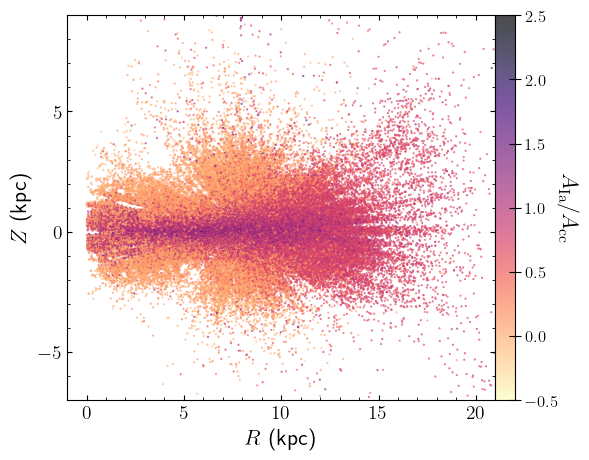

In [5]:
# select stars with <1 kpc distance errors - this will result in mostly disk stars
mask = np.where((astronn_matched['GALR_ERR']<1) & (astronn_matched['GALZ_ERR']<1))[0]

fig = plt.figure(figsize=(6.5,5))
points = plt.scatter(astronn_matched['GALR'][mask], astronn_matched['GALZ'][mask], c=(twoprocess_matched['A_IA']/twoprocess_matched['A_CC'])[mask], 
                  edgecolor='none', marker='.', s=10, alpha=0.7, cmap='magma_r', vmin=-0.5, vmax=2.5)
plt.xlim(-1,21)
plt.ylim(-7,9)
plt.xlabel(r'$R$ (kpc)', fontsize=16)
plt.ylabel(r'$Z$ (kpc)', fontsize=16)
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().tick_params(axis='y', which='both', direction='in', labelsize=14, right=True)
plt.gca().tick_params(axis='x', which='both', direction='in', top=True, labelsize=14)

cb = fig.colorbar(points, pad=0)
cb.ax.set_ylabel(r'$A_{\rm Ia}/A_{\rm cc}$', rotation=270, labelpad=15, fontsize=16)
cb.ax.tick_params(axis='y', which='major', labelsize=12, direction='inout', length=8)

Below, we plot $A_{\rm Ia}/A_{\rm cc}$ as a function of $A_{\rm cc}$, as in Sit et al. Figure 6, across different locations across the Galactic disk ($R$ = 3-13 kpc, $|Z|$ = 0-2 kpc). We use the same better-measured distances as the previous plot, with distance errors <1 kpc. We also provide lines of code (currently commented out) that will plot age from AstroNN on the x-axis instead, reproducing a plot similar to that of [Weinberg et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJS..260...32W/abstract) Figure 17.

In [6]:
# calculate high and low alpha samples following Sit et al. Equation 2 for the next plot
high_a = np.full(len(twoprocess_matched), fill_value=False)
for i in range(len(twoprocess_matched)):
    feh = twoprocess_matched['FE_H_ASPCAP_RAW'][i]
    mgfe = twoprocess_matched['MG_H_ASPCAP_RAW'][i] - twoprocess_matched['FE_H_ASPCAP_RAW'][i]
    if feh>0:
        high_a[i] = mgfe>0.12
    elif feh<0:
        high_a[i] = mgfe>0.12-(0.13*feh)

Text(0.5, 0.01, '$A_{\\rm cc}$')

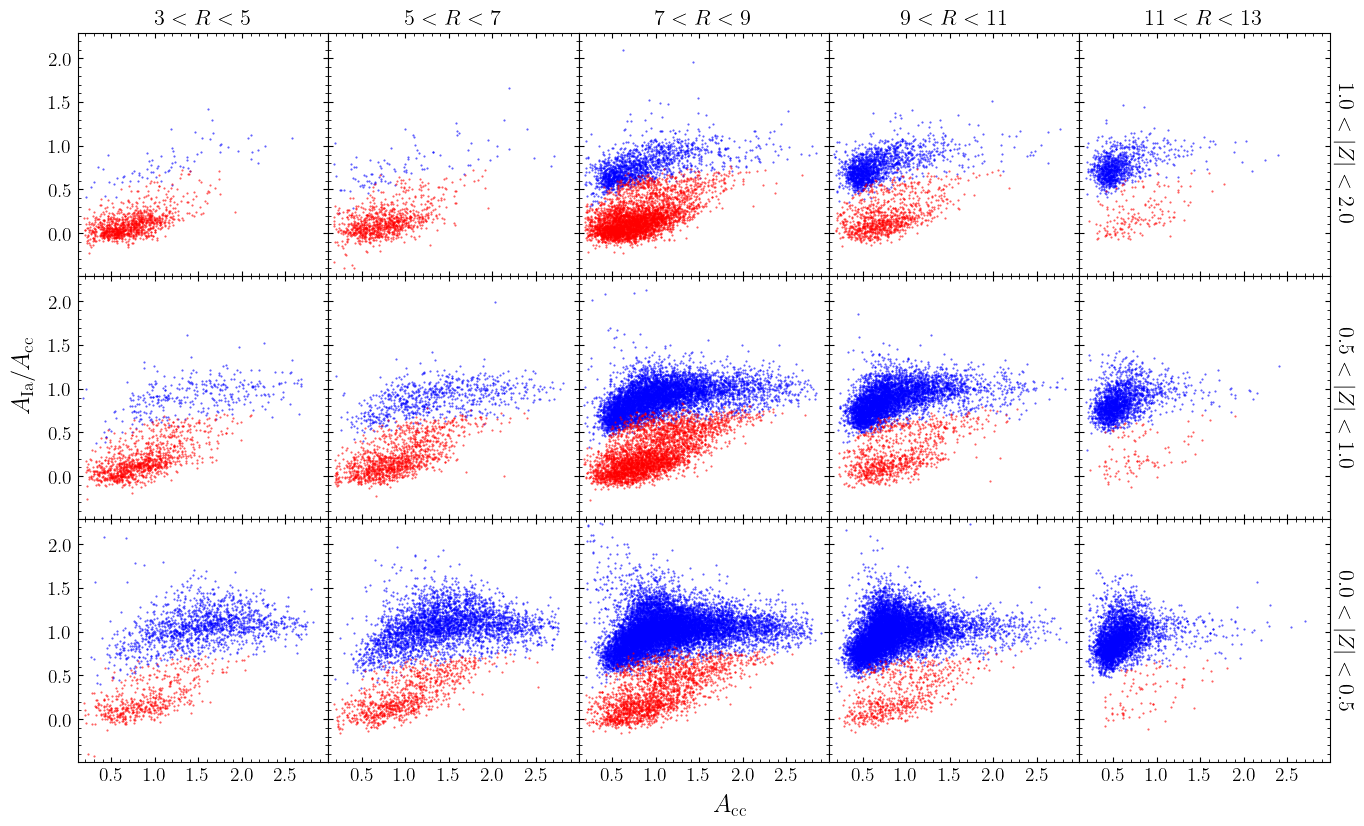

In [7]:
galr_bin_edges = np.arange(3, 15, 2)
galz_bin_edges = np.array([2, 1, 0.5, 0])

fig, axs = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(15,9))
for i, right_z_edge in enumerate(galz_bin_edges[:3]):
    in_z_bin = np.logical_and(np.abs(astronn_matched['GALZ'][mask])<right_z_edge, np.abs(astronn_matched['GALZ'][mask])>galz_bin_edges[i+1])
    
    for j, left_r_edge in enumerate(galr_bin_edges[:5]):
        in_r_bin = np.logical_and(np.abs(astronn_matched['GALR'][mask])>left_r_edge, np.abs(astronn_matched['GALR'][mask])<galr_bin_edges[j+1])
        in_bin = np.logical_and(in_z_bin, in_r_bin)
        in_bin_lowIa = np.logical_and(in_bin, high_a[mask])
        in_bin_highIa = np.logical_and(in_bin, ~high_a[mask])
        
        # uncomment below to plot astroNN ages on the x-axis instead
        #axs[i,j].scatter(astronn_matched['age_lowess_correct'][mask][in_bin_highIa][::4], (twoprocess_matched['A_IA']/twoprocess_matched['A_CC'])[mask][in_bin_highIa][::4],
        #                 c='b', marker='.', s=1, alpha=0.7)
        #axs[i,j].scatter(astronn_matched['age_lowess_correct'][mask][in_bin_lowIa][::4], (twoprocess_matched['A_IA']/twoprocess_matched['A_CC'])[mask][in_bin_lowIa][::4], 
        #                 c='r', marker='.', s=1, alpha=0.7)
        
        # comment out below lines if plotting age on x-axis
        axs[i,j].scatter(twoprocess_matched['A_CC'][mask][in_bin_highIa][::4], (twoprocess_matched['A_IA']/twoprocess_matched['A_CC'])[mask][in_bin_highIa][::4],
                         c='b', marker='.', s=1, alpha=0.7)
        axs[i,j].scatter(twoprocess_matched['A_CC'][mask][in_bin_lowIa][::4], (twoprocess_matched['A_IA']/twoprocess_matched['A_CC'])[mask][in_bin_lowIa][::4], 
                         c='r', marker='.', s=1, alpha=0.7)
        
        axs[i,j].tick_params(axis='y', which='both', direction='in', labelsize=14, right=True)
        axs[i,j].tick_params(axis='x', which='both', direction='in', top=True, labelsize=14)
        
        if i==0:
            axs[i,j].set_title(fr'${left_r_edge}<R<{galr_bin_edges[j+1]}$', fontsize=16)
            if j==0:
                axs[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
                axs[i,j].yaxis.set_major_locator(MultipleLocator(0.5))
                
                # uncomment below lines if plotting astroNN ages
                #axs[i,j].xaxis.set_minor_locator(MultipleLocator(1))
                #axs[i,j].xaxis.set_major_locator(MultipleLocator(5))
                #axs[i,j].set_ylim(-0.2,1.9)
                #axs[i,j].set_xlim(0,14)
                
                # comment out below lines if plotting ages
                axs[i,j].xaxis.set_minor_locator(MultipleLocator(0.1))
                axs[i,j].xaxis.set_major_locator(MultipleLocator(0.5))
                axs[i,j].set_ylim(-0.49,2.29)
                axs[i,j].set_xlim(0.11,2.99)
                
        if j==4:
            axs[i,j].set_ylabel(fr'${galz_bin_edges[i+1]}<|Z|<{right_z_edge}$', rotation=-90, fontsize=16, labelpad=18)
            axs[i,j].yaxis.set_label_position('right')
            
fig.subplots_adjust(hspace=0, wspace=0, left=0.065, bottom=0.07)
fig.supylabel(r'$A_{\rm Ia}/A_{\rm cc}$', fontsize=18)

# use appropriate x-axis label for what you're plotting!
#fig.supxlabel('Age (Gyr)', fontsize=16)
fig.supxlabel(r'$A_{\rm cc}$', fontsize=18)

### Plot globular cluster median residual abundances
In this section, we reproduce the right hand side of Sit et al. Figure 14.\
The Schiavon et al. (2023) DR17 globular cluster VAC can be accessed at: https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=apogee-globular-cluster-members-catalog

In [4]:
# load globular cluster catalog - adjust file path as necessary
with fits.open('GC_members_VAC-v1_1.fits') as hdul:
    cluster_member_data = hdul[1].data

In [5]:
# cross-match the catalogs
twoprocess_gc_matched, gc_data_matched = cross_match_catalogs(cluster_member_data, twoprocess_data)

  0%|          | 0/7737 [00:00<?, ?it/s]

Next, we'll make some tighter constraints on the GC stars. In Sit et al. (2024), we selected only "Likely" stars from the Schiavon et al. (2023) catalog (`iFlag==0`) with membership probability $>$0.8 (`RV_Prob>0.8` or `VB_Prob>0.8`). We also imposed a SNR cut of `SNR>100` for more robust residual abundances. Due to contaimination from Sgr in M54, particularly at the relatively high metallicities of the residual abundance catalog, we also removed M54.

In [6]:
prob_cuts = np.logical_or(gc_data_matched['RV_Prob']>0.8, gc_data_matched['VB_PROB']>0.8)
likely = np.logical_and(gc_data_matched['iFlag']==0, prob_cuts)
snr_cut = np.logical_and(twoprocess_gc_matched['SNR']>=100, likely)
noM54_mask = np.logical_and(gc_data_matched['GC_NAME']!='NGC6715', snr_cut)

In [7]:
# apply the likely+no M54 mask to the cross-matched data
gc_data_matched = gc_data_matched[noM54_mask]
twoprocess_gc_matched = twoprocess_gc_matched[noM54_mask]

Obtain a list of unique GCs represented in our sample and the number of stars in each:

In [8]:
cluster_names, num_stars_in_cluster = np.unique(gc_data_matched['GC_NAME'], return_counts=True)
Table((cluster_names, num_stars_in_cluster))

<Table length=22>
  col0   col1
 str18  int64
------- -----
Djorg_2     2
Liller1     4
NGC0104   231
NGC1851     1
NGC5139    81
NGC6121   159
NGC6171    22
NGC6304     8
NGC6316     4
NGC6380    14
NGC6388    16
NGC6540     1
NGC6553     3
NGC6569     6
NGC6723     3
NGC6760     9
NGC6838    86
   Pal6     4
  Ter12     1
   Ter2     3
   Ter5     3
   Ton2     3

We select GCs with $N>8$ stars for our final sample:

In [9]:
cluster_names = cluster_names[num_stars_in_cluster>8]
num_stars_in_cluster = num_stars_in_cluster[num_stars_in_cluster>8]

# this is to re-order so that oCen is last
gcs = cluster_names[np.argsort(num_stars_in_cluster)[::-1]][[0,1,2,4,5,6,7,3]]
gc_count = num_stars_in_cluster[np.argsort(num_stars_in_cluster)[::-1]][[0,1,2,4,5,6,7,3]]
Table((gcs, gc_count))

<Table length=8>
  col0   col1
 str18  int64
------- -----
NGC0104   231
NGC6121   159
NGC6838    86
NGC6171    22
NGC6388    16
NGC6380    14
NGC6760     9
NGC5139    81

The next cell will set up some functions and arrays to generate the median residual abundance plot. The functions are generalizable to any star or population you want to generate residual abundance plots for.

In [10]:
from scipy.stats import bootstrap

# list of elements
all_elems = np.array(['O_aspcap', 'Mg_aspcap', 'Si_aspcap', 'S_aspcap', 'Ca_aspcap', 'C+N_aspcap', 'Na_aspcap', 'Al_aspcap', 'K_aspcap', 
                      'Cr_aspcap', 'Fe_aspcap', 'Ni_aspcap', 'V_aspcap', 'Mn_aspcap', 'Co_aspcap', 'Ce_aspcap', 'Cu_bawlas', 
                      'O_bawlas', 'S_bawlas', 'C+N_bawlas', 'Na_bawlas', 'V_bawlas', 'Ce_bawlas'])

# names of GCs, in the formatting we want to plot them with
gc_names = np.array(['47 Tuc', 'M4', 'M71', 'M107', 'NGC 6388', 'NGC 6380', 'NGC 6760', r'$\omega$ Cen'])

def gen_elem_ticks_labels():
    # Generates x-axis labels for a residual abundance plot.
    elem_names = []
    for i, elem in enumerate(all_elems):
        ele, source = elem.split('_')
        if 'aspcap' in source:
            # Underline elements used to fit the two-process model
            if (ele=='Mg') or (ele=='O') or (ele=='Si') or (ele=='Ca') or (ele=='Fe') or (ele=='Ni'):
                elem_names.append(r'\underline{%s}' % ele)
            else:
                elem_names.append(ele)
        else:
            elem_names.append(ele)
            
    return elem_names

def gen_array_for_2proc_dev_plot(ind, twoproc_data):
    """
    Generate an array of residual abundances in the order of all_elems for one star.
    Input
    -----
    ind : int
          Index of twoproc_data corresponding to the star
    twoproc_data : recarray
                   Data from 
    Output
    ------
    y_data : 1D array (dtype=float)
    """
    y_data = np.empty(len(all_elems))
    for i, elem in enumerate(all_elems):
        elem = elem.upper()
        ele, source = elem.split('_')
        y_data[i] = twoproc_data[ind][ele+'_H_'+source+'_DEV']
    
    return y_data

def calc_2proc_dev_medians_and_errors(sample_star_inds, twoproc_data):
    """
    Calculate median residual values and bootstrap errors on the median for a list of stars.
    Input
    -----
    sample_star_inds : array-like of int
                       List or array of indices
    twoproc_data : recarray
                   
    
    Output
    ------
    median_y_vals : 1D array (dtype=float)
                    
    median_y_vals_bootstrap_std : 1D array (dtype=float)
                                  
    """
    y_data_arr = np.empty((len(sample_star_inds),len(all_elems)))

    for j, ind in enumerate(sample_star_inds):
        y_data_arr[j] = gen_array_for_2proc_dev_plot(ind, twoproc_data)

    median_y_vals = np.nanmedian(y_data_arr, axis=0)
    median_y_vals_bootstrap_std = np.empty_like(median_y_vals)

    for k in range(len(all_elems)):
        if np.isnan(median_y_vals[k]):
            median_y_vals_bootstrap_std[k] = np.nan
        else:
            bootstrap_result = bootstrap((y_data_arr[:,k],), np.nanmedian, n_resamples=1000, confidence_level=0.9)
            median_y_vals_bootstrap_std[k] = bootstrap_result.standard_error
    
    return median_y_vals, median_y_vals_bootstrap_std

def calc_num_bawlas(gc_inds):
    i = 0
    nanarr = np.full((7, len(gc_inds)), False, dtype=bool)
    for elem in all_elems:
        elem = elem.upper()
        ele, source = elem.split('_')
        if source=='BAWLAS':
            abunds = twoprocess_gc_matched[gc_inds][ele+'_H_'+source+'_ADJ']
            nanarr[i,:] = ~np.isnan(abunds)
            i+=1
    num_not_nan = np.sum(np.any(nanarr, axis=0))
    return num_not_nan

elem_names = gen_elem_ticks_labels()

Code to generate the residual abundance plot below:

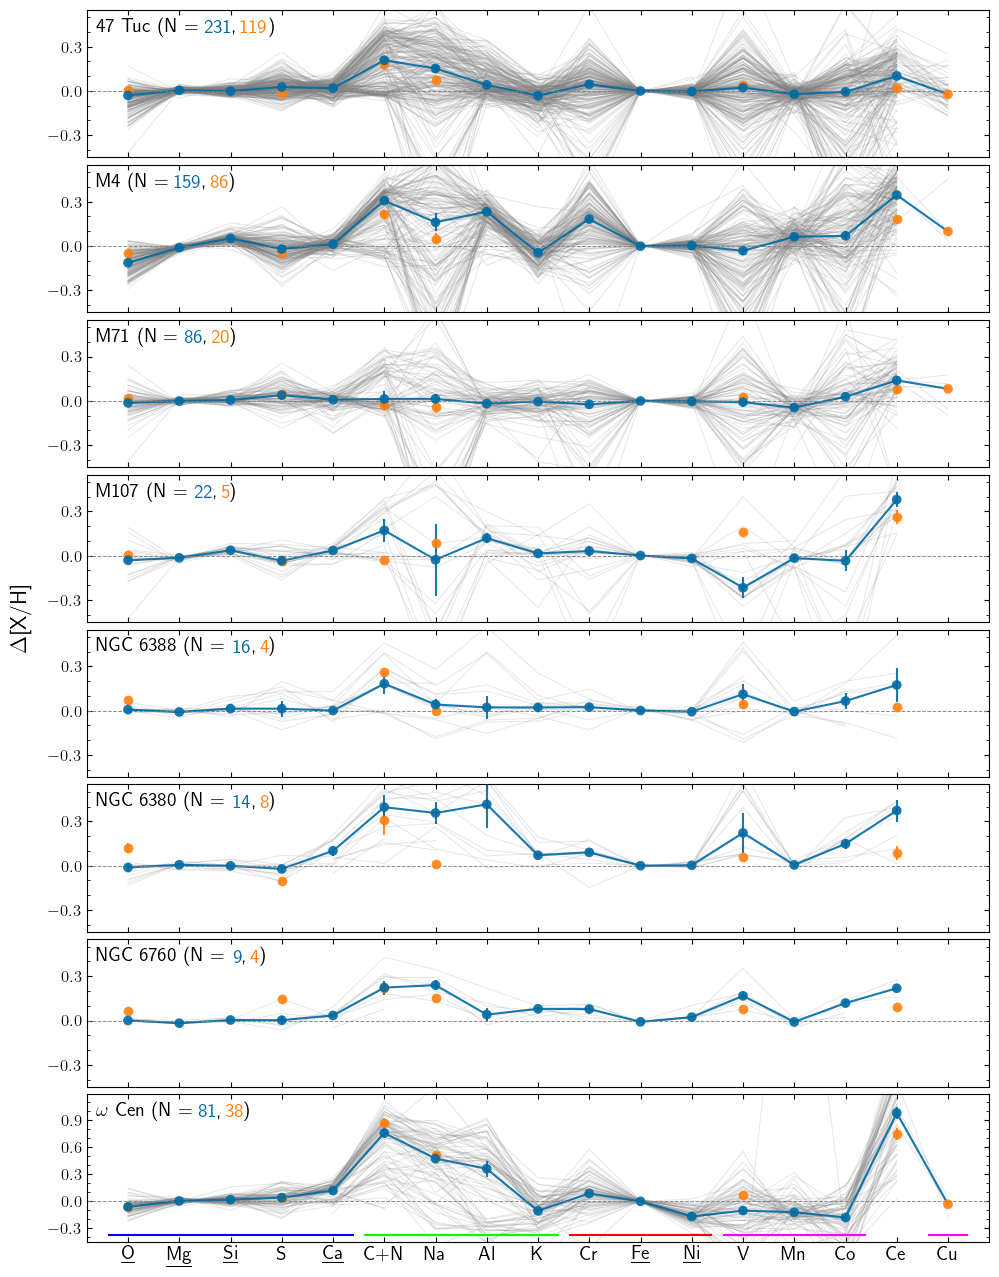

In [11]:
# FYI: the warnings pop up from trying to run bootstrap on an element with 0-1 measurements in the GC
# and matplotlib being fussy about relabeling the x-axis ticks
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

fig, axs = plt.subplots(len(gcs), 1, sharex=True, figsize=(11,2*len(gcs)))

resid_plot_colors = np.full(17, '#006BA4', dtype='<U7')
resid_plot_colors[16] = '#FF800E'

for i, gc in enumerate(gcs):
    gc_inds = np.where(gc_data_matched['GC_NAME']==gc)[0]
    median_y_vals, median_y_vals_std = calc_2proc_dev_medians_and_errors(gc_inds, twoprocess_gc_matched)
    num_bawlas = calc_num_bawlas(gc_inds)

    for ind in gc_inds:
        y_data = gen_array_for_2proc_dev_plot(ind, twoprocess_gc_matched)
        axs[i].plot(all_elems[:17], y_data[:17], ls='-', alpha=0.2, c='gray', lw=0.7)
        
    for e, bawlas_elem in enumerate(all_elems[17:]):
        el, _ = bawlas_elem.split('_')
        matching_ind = np.where(all_elems==f'{el}_aspcap')[0][0]
        axs[i].errorbar(all_elems[matching_ind], median_y_vals[17+e], yerr=median_y_vals_std[17+e], marker='o', c='#FF800E', ls='-', ms=7, alpha=0.9, mec='none')
        
    axs[i].errorbar(all_elems[:16], median_y_vals[:16], yerr=median_y_vals_std[:16], marker='', c='#006BA4', ls='', ms=7, alpha=0.9)
    axs[i].errorbar(all_elems[16], median_y_vals[16], yerr=median_y_vals_std[16], marker='', c='#FF800E', ls='', ms=7, alpha=0.9)
    axs[i].plot(all_elems[:17], median_y_vals[:17], c='#006BA4', alpha=0.9)
    axs[i].scatter(all_elems[:17], median_y_vals[:17], marker='o', c=resid_plot_colors, alpha=0.9, edgecolors='none', s=49, zorder=3)
    axs[i].axhline(0, c='gray', ls='--', lw=0.7, alpha=0.9)
    text = axs[i].text(0.01, 0.95, gc_names[i]+' (N = ', fontsize=14, va='top', ha='left', transform=axs[i].transAxes)
    text = axs[i].annotate(f' {gc_count[i]}', xycoords=text, xy=(1.05,0), fontsize=14, va='bottom', color='#006BA4')
    text = axs[i].annotate(', ', xycoords=text, xy=(1,0), fontsize=14, va='bottom')
    text = axs[i].annotate(f' {num_bawlas}', xycoords=text, xy=(1.5,0), fontsize=14, va='bottom', color='#FF800E')
    text = axs[i].annotate(')', xycoords=text, xy=(1,0), fontsize=14, va='bottom')
    axs[i].yaxis.set_minor_locator(MultipleLocator(0.1))
    axs[i].yaxis.set_major_locator(MultipleLocator(0.3))
    axs[i].tick_params(axis='y', which='both', direction='in', labelsize=12, right=True)
    axs[i].tick_params(axis='x', direction='in', top=True, labelsize=14)
    axs[i].set_xticklabels(elem_names[:17])
                
    if gc=='NGC5139': # different y-axis limits for oCen
        axs[i].set_ylim(-0.45, 1.19)
    else:
        axs[i].set_ylim(-0.45,0.55)

xlims = axs[1].get_xlim()

# colored lines to indicate element groups
axs[-1].hlines(-0.37, -0.4, 4.4, color='b', lw=1.5)
axs[-1].hlines(-0.37, 4.6, 8.4, color='lime', lw=1.5)
axs[-1].hlines(-0.37, 8.6, 11.4, color='r', lw=1.5)
axs[-1].hlines(-0.37, 11.6, 14.4, color='magenta', lw=1.5)
axs[-1].hlines(-0.37, 15.6, 16.4, color='magenta', lw=1.5)

axs[-1].set_xlim(xlims)

fig.supylabel(r'$\Delta$[X/H]', fontsize=16, x=0.01)
fig.subplots_adjust(left=0.08, hspace=0.05)